<a href="https://colab.research.google.com/github/almohaah/MASc-Thesis/blob/master/data_processing_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os
import random

In [ ]:
def record_net_data_stats(y_train, net_dataidx_map):
    net_cls_counts = {}
    y_train = y_train.to_numpy()
    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp
    return net_cls_counts


In [ ]:
#get 4 train and 4 test sets
def partition_data(dataset, partition, n_nets, alpha , y_name, data_percentage, partition_att=None,batch_size=10,part=4,is_clients=True):
    """
    - dataset: a dataframe (Pandas)
    - partition: type of partitioning to perform
    hetero-say: heterogeneous partition by given sensitive attribute and target variable
    - y_name: name of the class/label column in a dataframe
    - partition_att: the attribute to perform the partitioning with ... in our case, this should be the sensitive attribute column name
    - n_nets = number of clusters/clients (4 for clusters and 80 for users)
    - alpha = concentration parameter of the Dirchlet dist.

    """

    #Step0:
      #Assign heterogenity index to each datapoint
      #Retrieve features X & Labels y
      #Split data into train & test sets
      #Re-index train & test data
    if not is_clients:
        dataset['Hetero_index'] = dataset.groupby([partition_att,y_name]).ngroup()
        #gives each datapoint a heterogenity index [0:3]
        #output two columns (datapoint index : Hetero index)

    X_train, y_train = dataset.drop(y_name, axis=1), dataset[y_name]
    X_train.reset_index(inplace=True, drop=False)
    #reset the indices of the panda frame to be ordered (0, 1,2, ....)

    n_train = X_train.shape[0]
    net_dataidx_map_test = None
    #==========================================================================

    if partition == "homo":
        total_num = n_train
        idxs = np.random.permutation(total_num)
        batch_idxs = np.array_split(idxs, n_nets)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_nets)}

        traindata_cls_counts = record_net_data_stats(X_train[partition_att], net_dataidx_map)
    #==========================================================================
    elif partition == "hetero":
        min_size = 0
        K = len(np.unique(y_train))
        N = y_train.shape[0]
        net_dataidx_map = {}
        traindata_cls_counts= {}

        while min_size < batch_size:
            idx_batch = [[] for _ in range(n_nets)]
            # for each class in the dataset
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
                ## Balance
                proportions = np.array([p * (len(idx_j) < N / n_nets) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_nets):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

        traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map)
    #==========================================================================
    elif partition == "hetero-sa":
        min_size = 0
        min_class = 0
        sa = X_train[partition_att]
        K = len(np.unique(sa))
        N = sa.shape[0]
        net_dataidx_map = {}
        traindata_cls_counts={}

        if alpha == 0 or alpha==-1:
            hard_alpha = [5,0.5]
            # Hard coded experiment
            # Extreme splitting  (Split each group into one client)
            n_nets_cluster = [2,3]
            for a in range(K):
                min_size = 0
                N = (sa==a).sum()
                K = len(np.unique(y_train))
                while min_size < batch_size  or min_class == 0:
                    idx_batch = [[] for _ in range(n_nets_cluster[a])]
                    past_min_class = np.infty
                    pts_split_all_classes = [None,None]
                    # for each class in the dataset
                    for k in range(K):
                        idx_k = np.where((y_train == k)&(sa==a))[0]
                        np.random.shuffle(idx_k)
                        proportions = np.random.dirichlet(np.repeat(hard_alpha[int(alpha)], n_nets_cluster[a]))
                        ## Balance
                        proportions = np.array([p * (len(idx_j) < N / n_nets_cluster[a]) for p, idx_j in zip(proportions, idx_batch)])
                        proportions = proportions / proportions.sum()
                        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                        pts_split = np.split(idx_k, proportions)
                        idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, pts_split)]
                        min_size = min([len(idx_j) for idx_j in idx_batch])
                        min_class = min([len(A) for A in pts_split]+[past_min_class])
                        past_min_class = min_class

                        pts_split_all_classes[k] = pts_split


                for j in range(n_nets_cluster[a]):
                    np.random.shuffle(idx_batch[j])
                    net_dataidx_map[j+a*2] = idx_batch[j]

            traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map)

        else:
            while min_size < batch_size or min_class == 0:
                idx_batch = [[] for _ in range(n_nets)]
                past_min_class = np.infty
                # for each class in the dataset
                pts_split_all_classes = [None,None]
                for k in range(K):
                    idx_k = np.where(sa == k)[0]
                    np.random.shuffle(idx_k)
                    proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
                    ## Balance
                    proportions = np.array([p * (len(idx_j) < N / n_nets) for p, idx_j in zip(proportions, idx_batch)])
                    proportions = proportions / proportions.sum()
                    proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                    pts_split = np.split(idx_k, proportions)
                    idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, pts_split)]
                    min_size = min([len(idx_j) for idx_j in idx_batch])
                    min_class = min([len(A) for A in pts_split]+[past_min_class])
                    past_min_class = min_class

                    pts_split_all_classes[k] = pts_split

            for j in range(n_nets):
                np.random.shuffle(idx_batch[j])
                net_dataidx_map[j] = idx_batch[j]

            traindata_cls_counts = record_net_data_stats(sa, net_dataidx_map)
    #==========================================================================
    elif partition == "hetero-say":
        #Step-1:
          # For each heterogenity index K=k:
           # 1) Obtain indcies of datapoints to be assigned to every cluster/client
              # 1-a) First assign %10 of datapoint indcies of hetero-index K=k
                # idx_k = shuffled array of datapoint indcies with hetero-index k
                #Take 4 consecutive 10%-portions of idx_k and allocate to clusters/clients
                #update idx_k by removing what was assigned to clusters/clients
                #generate dirichlet proportions to split the remainder of idx_k across clusters/clients
                #If the proportions are such that one cluster/clientss takes datapoints more than #datapoints/#clusters, then set to zero and renormalize
                #Renormalize proportions


        min_size = 0
        K = len(np.unique(X_train['Hetero_index']))
        N = y_train.shape[0]
        net_dataidx_map = {}
        traindata_cls_counts={}

        while min_size < batch_size:
            idx_batch = [[] for _ in range(n_nets)]
            #pre-allocate arrays of indicies for the different clusters/clients

            #Forloop over each heterogenity index in the dataset
            for k in range(K):

                idx_k = np.where(X_train['Hetero_index'] == k)[0]

                np.random.shuffle(idx_k)
                #returns a shuffled array containing indcies of datapoints with hetero-index K=k


                if is_clients:
                    # 10% of datapoints with hetero index k
                    idx_batch = [idx_j + [idx_k[i]]for idx_j, i in zip(idx_batch, range(n_nets))]
                    idx_k= idx_k[n_nets:]
                    #remove first n_nets datapoints
                else:
                    # data_percentage% of datapoints for each cluster with hetero index k
                    pers=round(data_percentage*len(idx_k))
                    idx_batch = [idx_j + idx_k[i*pers:(i+1)*pers].tolist() for idx_j, i in zip(idx_batch, range(n_nets))]
                    idx_k= idx_k[n_nets*pers:]
                     #update idx_k by removing the first n_nets * pers indices (which were assigned to clients)
                    #this represents the remainder index array after the determinstic assignment
                    #of data_percentage% of hetero-index k to each cluster

                proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
                #same concentration parameter alpha for all clients/clusters
                #creates a vector of (remainder) proportions of data (with hetero index k=0,1,2,3)
                #to be given to clients

                ## Balance
                proportions = np.array([p * (len(idx_j) < N / n_nets) for p, idx_j in zip(proportions, idx_batch)])
                #If #datapoints in indx_j (cluster or client index) is >= no of data points / no of clusters/clients,
                    #then no more data points are assigned to this client/cluster
                # This is done to balance no of data points across clusters or clients.
                proportions = proportions / proportions.sum()
                #outcome of np.ritichlet is normalized;
                #but the constraint above might require re-normalization
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                #Defines the positions where the index array of hetero-index k (i.e., idx_k)
                # is split over clients/clusters according to defined proportions
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                #append the result of the split to the previous assignmetns
                min_size = min([len(idx_j) for idx_j in idx_batch])
                #if no of datapoints assigned to client j < batch size, re-split


        for j in range(n_nets):

            np.random.shuffle(idx_batch[j])
            if is_clients:
                net_dataidx_map[part*n_nets + j] = idx_batch[j]
            else:
                net_dataidx_map[j] = idx_batch[j]
            #Overall datapoint-indcies assigned to each cluster/client
            #part isused to counting from 0 to 79


        traindata_cls_counts = record_net_data_stats(X_train['Hetero_index'], net_dataidx_map)
        #Returns a 3-d dictionary with {key = cluster/client, value = {hetero_index: datapoints counts}}




    return X_train, y_train, net_dataidx_map, traindata_cls_counts

In [ ]:
# call this function to get the final data sets and indices

def get_data(c,dataset,partition, n_nets, alpha_low, alpha_high, data_percentage,test_clients, y_name, partition_att=None,batch_size=10):

    #number of clients in each cluster
    #n_nets

    #get 4 training sets and testing sets
    X_train, y_train, train_dataidx_map, train_data_cls_counts =\
    partition_data(dataset, partition, c, alpha_low, y_name, data_percentage, partition_att,batch_size,is_clients=False)
    X_train[y_name]=y_train

    # plot clusters data
    array_data_c = np.zeros((c, c))
    for i in range(c):
        for j in range(c):
            array_data_c[i][j] = train_data_cls_counts[i][j]

    new_array_c=pd.DataFrame(array_data_c)
    #2-d array of cluster hetero-index counts
    x_labels = [ str(i+1) for i in range(c)]
    ax=new_array_c.plot(kind='bar', stacked=True)
    ax.set_xticklabels(x_labels, rotation=90)
    plt.xlabel('User ID')
    plt.ylabel('Dataset Size')
    plt.title(f'Clusters data with alpha_cluster = {alpha_low} and alpha_clients = {alpha_high}')
    plt.savefig(f'Clusters data with alpha_cluster = {alpha_low} and alpha_clients = {alpha_high}.png')
    plt.show()

    train_data_map={}
    train_data_cls_counts={}
    test_data_map={}
    test_data_cls_counts={}
    X_test= pd.DataFrame(columns=X_train.columns)
    accum=0
    for i in range(c):

        df=X_train.loc[list(train_dataidx_map[i])]
        sa_counts=df['Sex'].value_counts().sort_index()

        X, y,  net_map, data_cls_counts = partition_data(df, partition, n_nets+test_clients, alpha_high , y_name,partition_att,batch_size,part=i)
        keyList = list(net_map.keys())
        random.shuffle(keyList)
        mappedPairs_net_map = (zip(keyList, net_map.values()))
        mappedPairs_data_cls_counts = (zip(keyList, data_cls_counts.values()))
        data_cls_counts=dict(mappedPairs_data_cls_counts)
        net_map=dict(mappedPairs_net_map)
        temp_dic={}
        temp_dic_t={}
        count_dic={}
        count_dic_t={}
        counts={0:0,1:0}
        counts_t={0:0,1:0}


        for j in range (n_nets):
            indeces=list(X['level_0'][list(net_map[i*25+j])])
            temp_dic[i*n_nets+j] = indeces
            count_dic[i*n_nets+j] =data_cls_counts[i*(n_nets+test_clients)+j]

        for j in range (test_clients):
            indeces=list(X['level_0'][list(net_map[i*(n_nets+test_clients)+n_nets+j])])
            temp_dic_t[i*n_nets//c+j] = indeces
            count_dic_t[i*n_nets//c+j] =data_cls_counts[i*(n_nets+test_clients)+n_nets+j]



        train_data_map.update(temp_dic)
        train_data_cls_counts.update(count_dic)
        test_data_map.update(temp_dic_t)
        test_data_cls_counts.update(count_dic_t)

    del X_train[y_name]


    return X_train, y_train, train_data_map,train_data_cls_counts,test_data_map,test_data_cls_counts

In [ ]:
#call this function to plot the data for all clients in each cluster



def plot_data(clients_num, cluster_num,train_data_cls_counts,alpha_cluster,alpha_clients ):

    array_data = np.zeros((clients_num, cluster_num))
    for i in range(clients_num):
        for j in range(cluster_num):
            array_data[i][j] = train_data_cls_counts[i][j]

    for k in range(cluster_num):
        new_array=np.zeros((int(clients_num/cluster_num),cluster_num))
        new_array=pd.DataFrame(array_data[k*int(clients_num/cluster_num):(k+1)*int(clients_num/cluster_num)][:])
        x_labels = [ str(i+1) for i in range(int(clients_num/cluster_num))]
            #ax.set_xticklabels(x_labels, rotation=0)

            # Plot the stacked bar chart
        ax=new_array.plot(kind='bar', stacked=True)
        ax.set_xticklabels(x_labels, rotation=90)

            # Set labels and title
        plt.xlabel('User ID')
        plt.ylabel('Dataset Size')
        ax.set_ylim([0, 1500])
        plt.title(f'Cluster {k+1} clients with alpha_cluster = {alpha_cluster} and alpha_clients = {alpha_clients} ')
        plt.savefig(f'Cluster {k+1} clients with alpha_cluster = {alpha_cluster} and alpha_clients = {alpha_clients}.png')
            # Display the chart

        plt.show()


* Start from here


In [ ]:

filename="./adult_clean.csv"
dataset=pd.read_csv(filename)

alpha_cluster = 0.1
data_percentage=0.1
alpha_clients = 50
partition="hetero-say"
#number of clients
clients_num=20
test_clients=5
# number of clusters
c=4

* to generate 50 version run this block

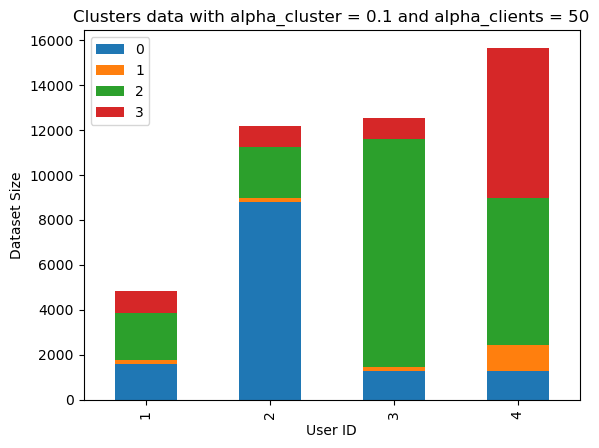

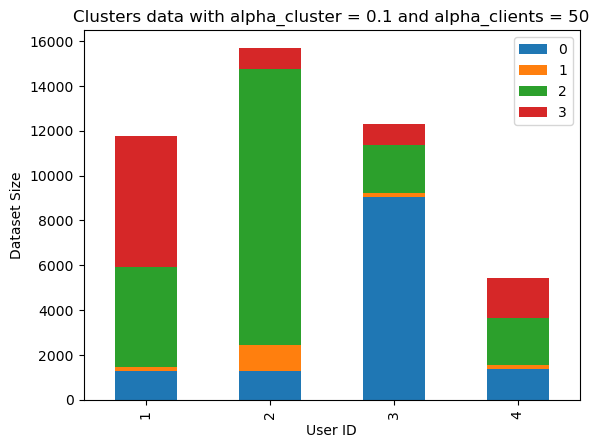

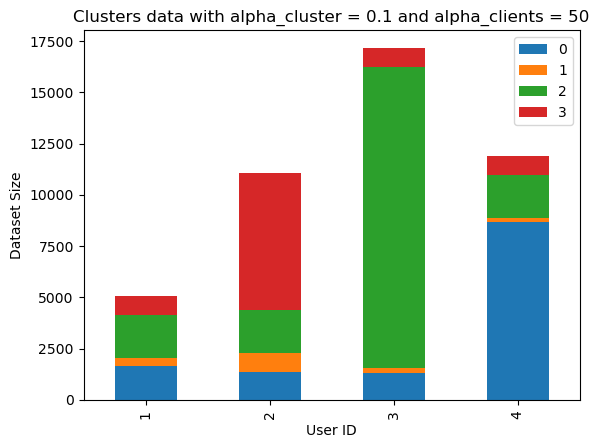

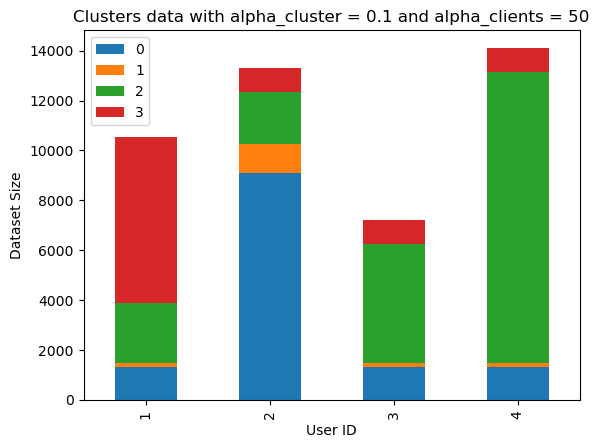

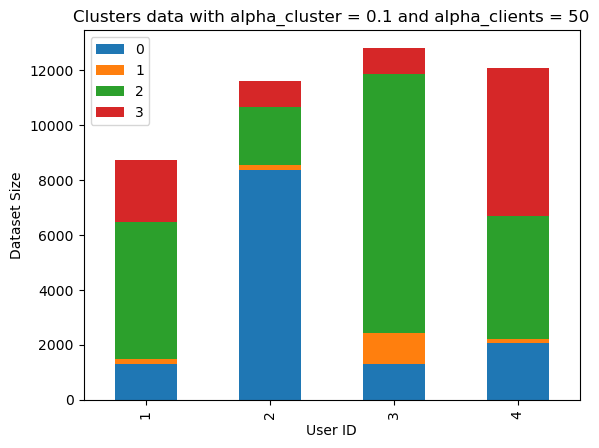

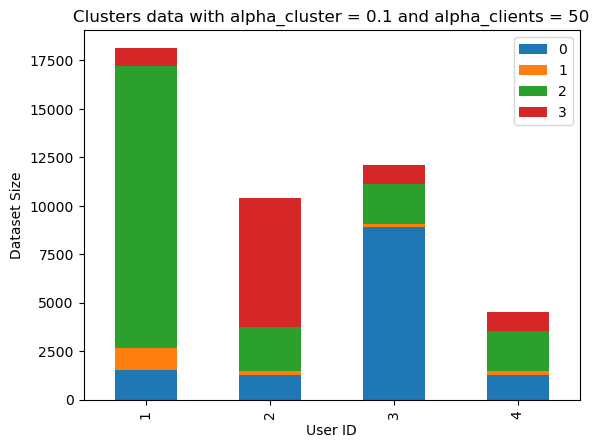

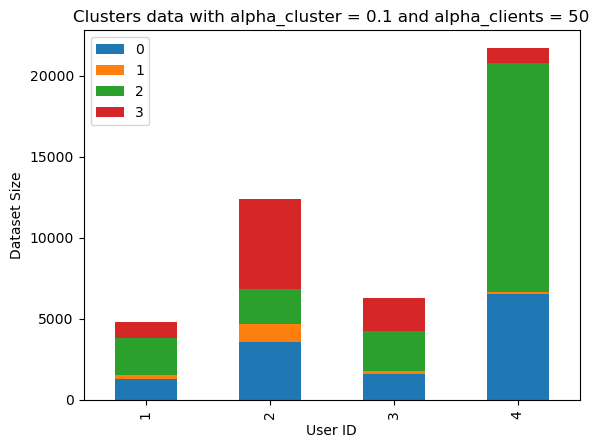

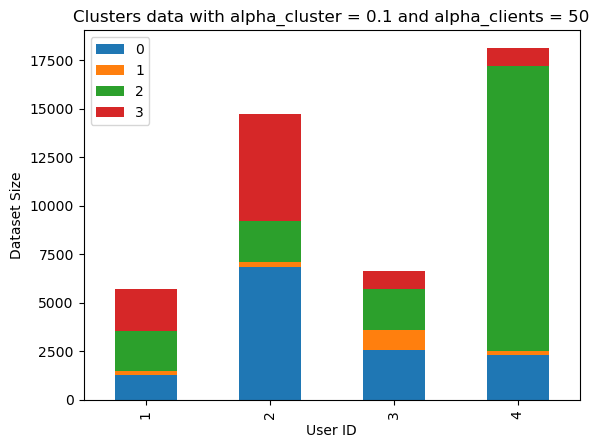

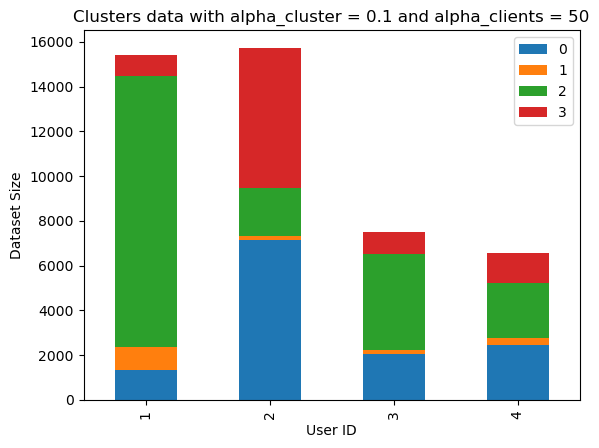

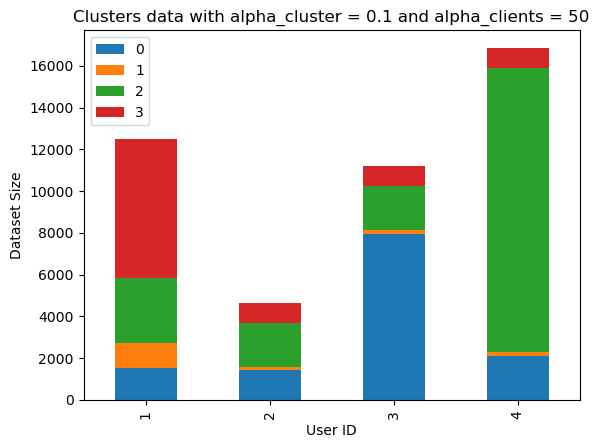

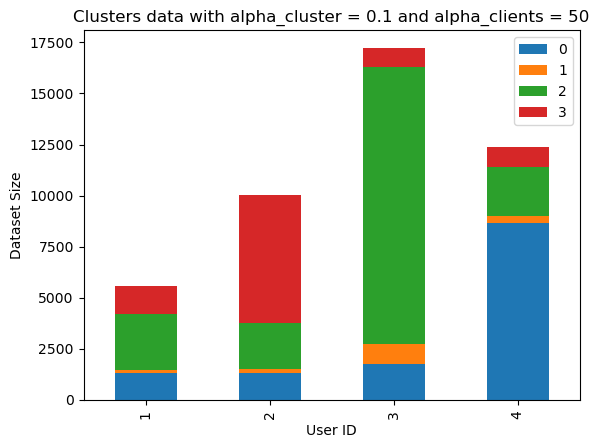

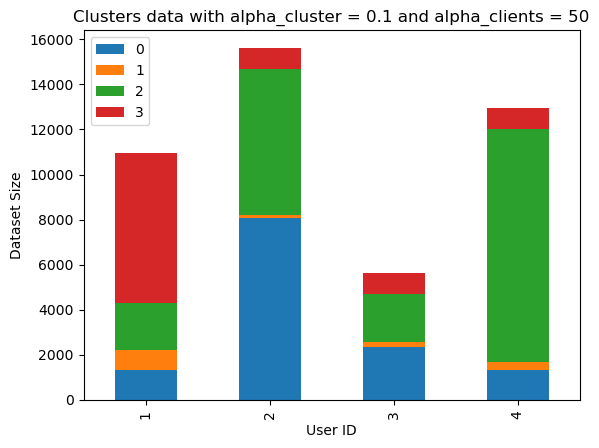

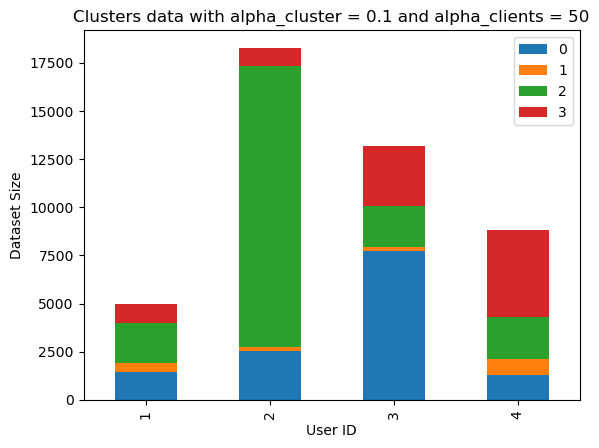

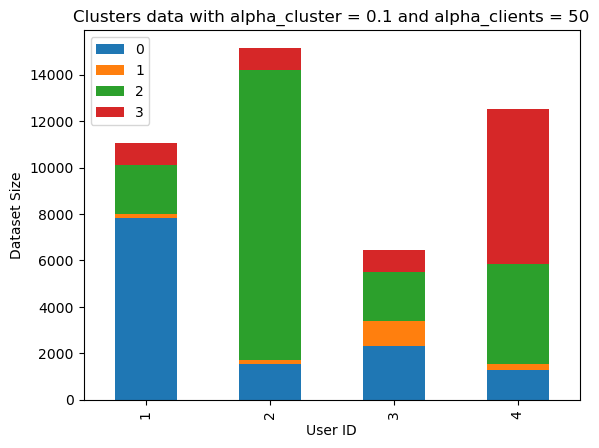

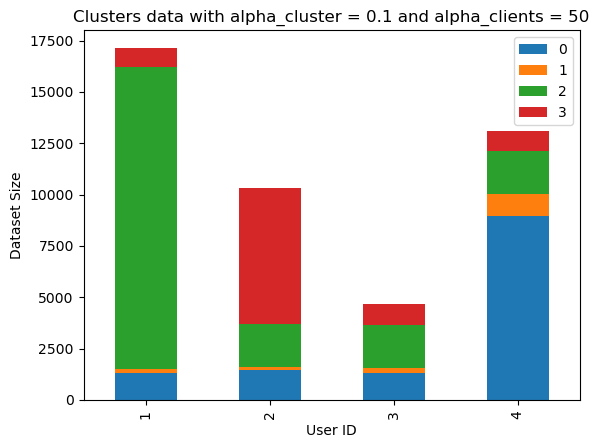

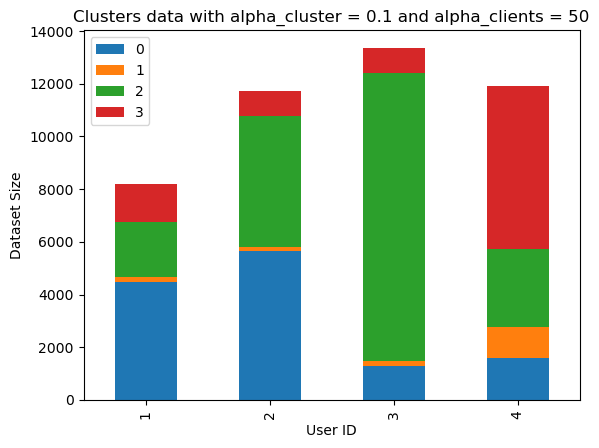

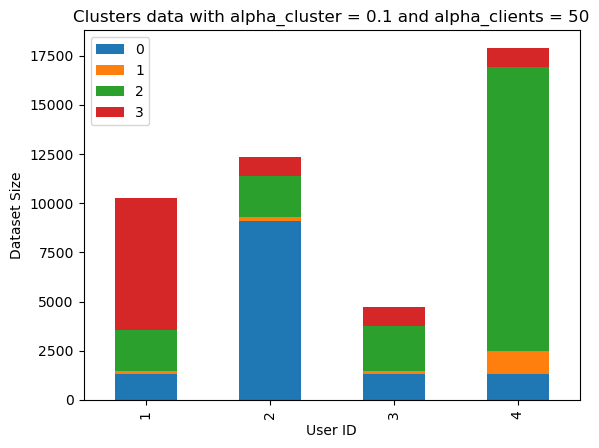

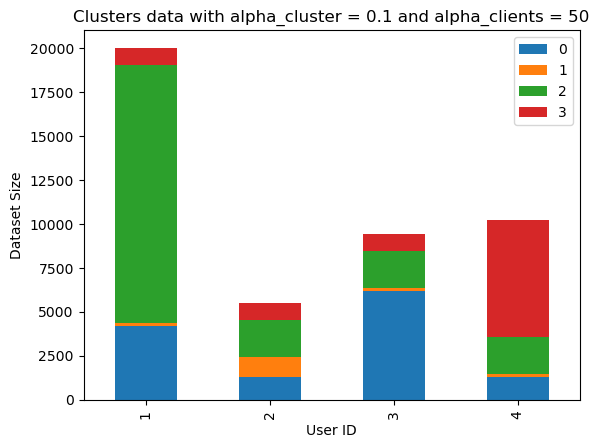

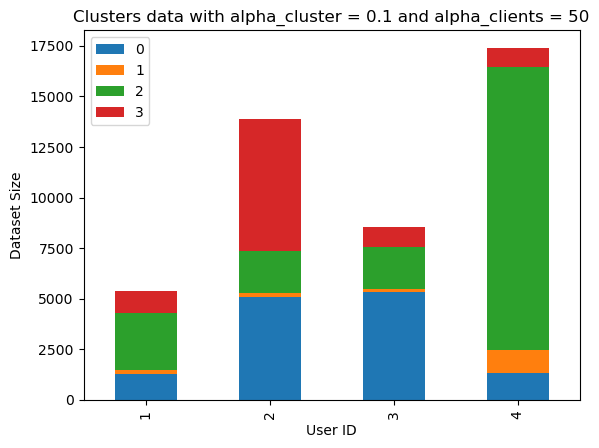

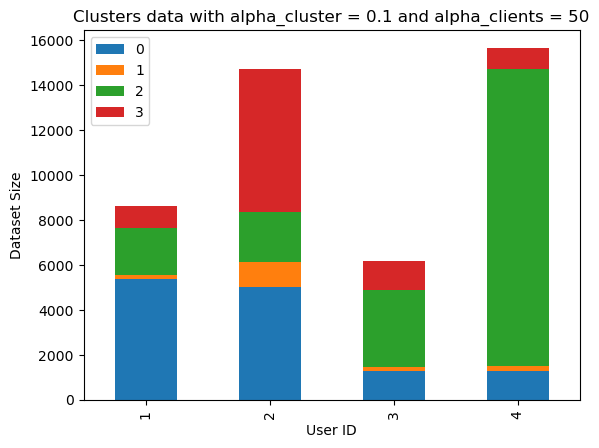

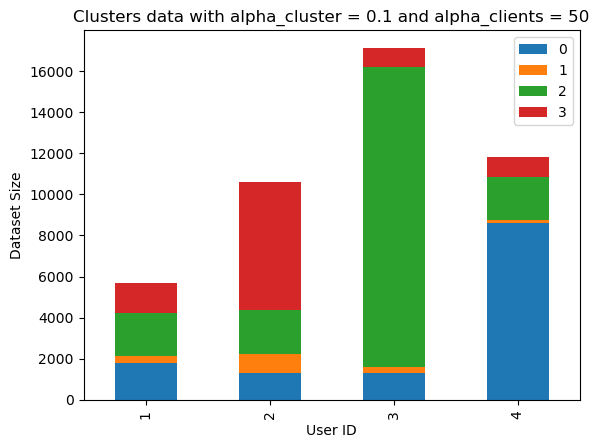

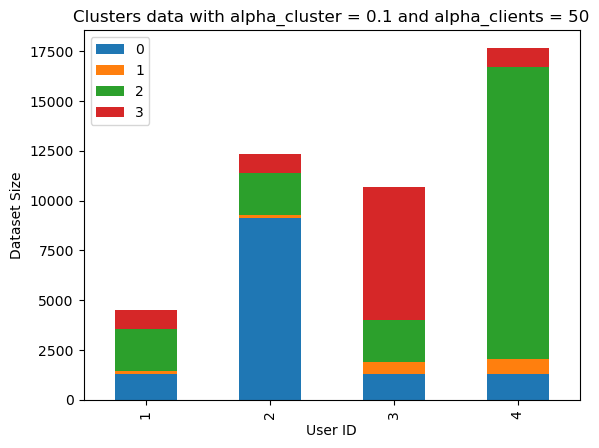

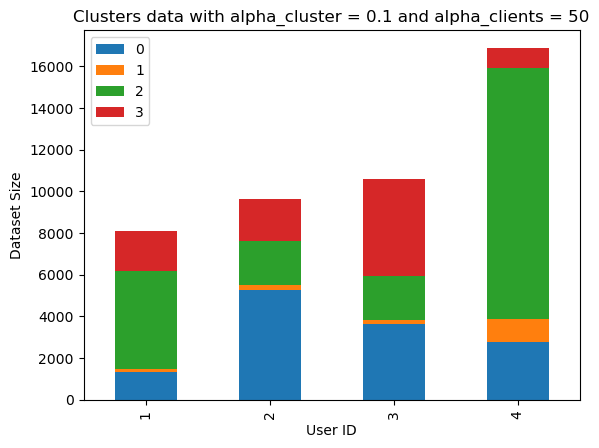

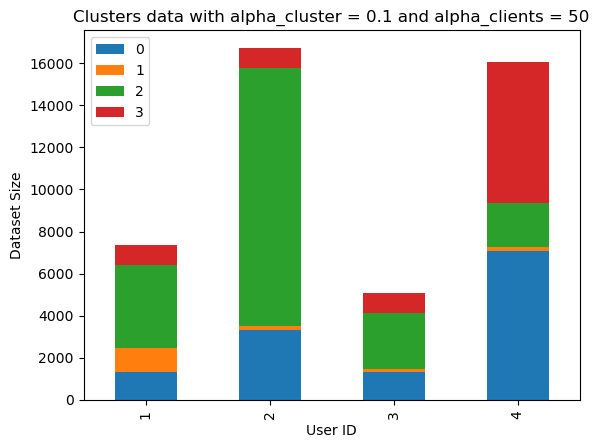

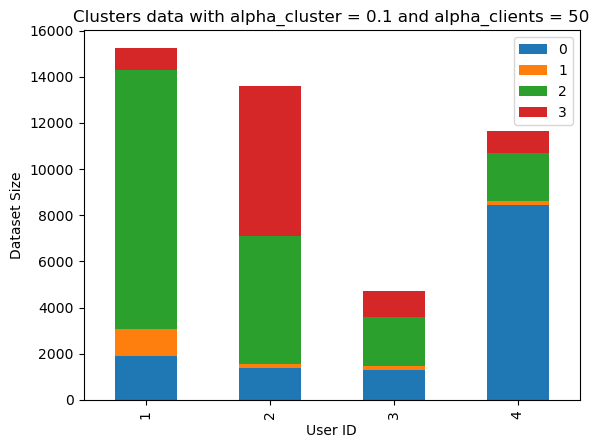

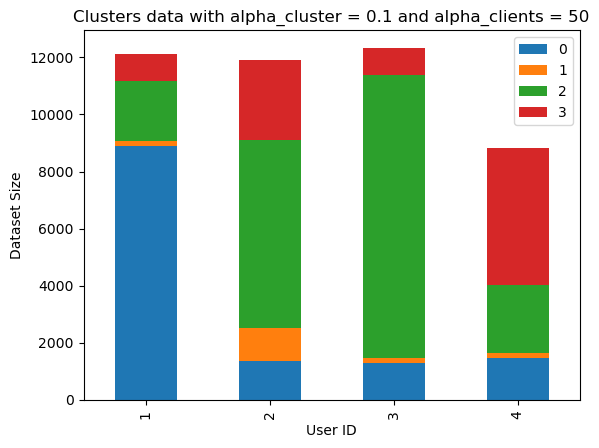

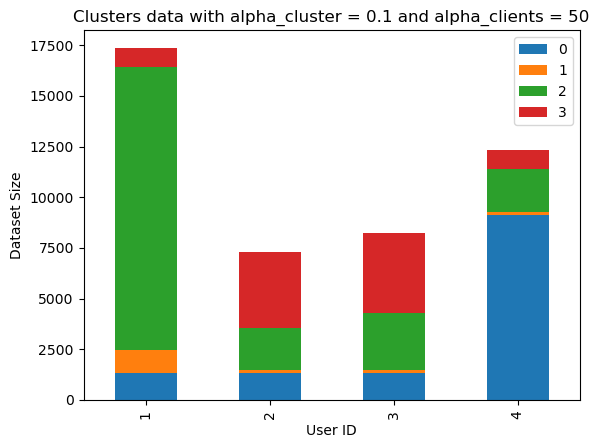

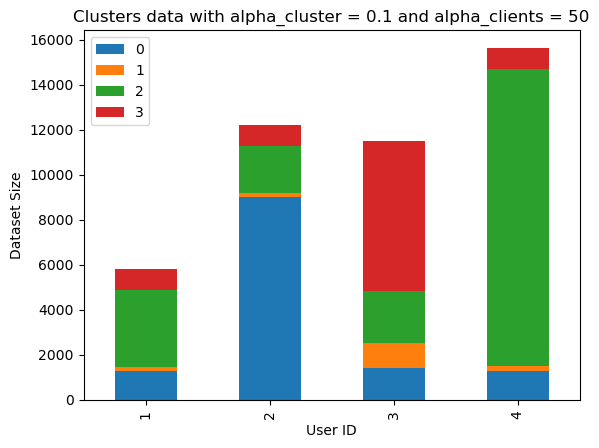

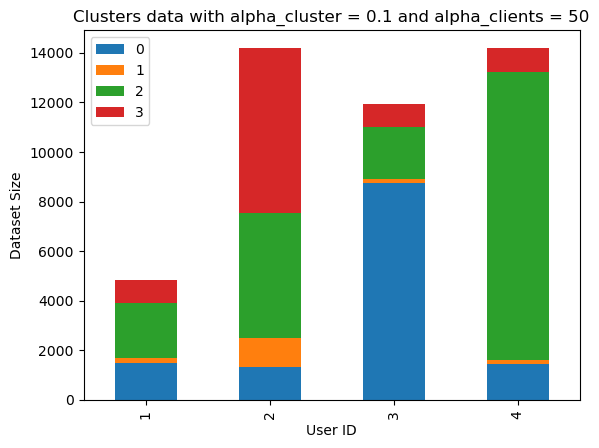

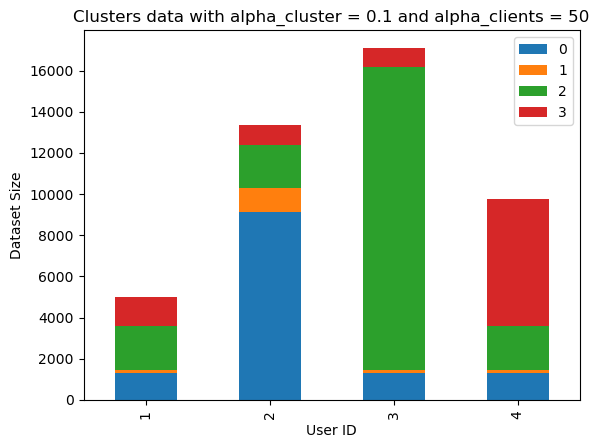

In [ ]:
num_of_version=30

for j in range(num_of_version):
    X_train, y_train, train_dataidx_map, train_data_cls_counts, test_dataidx_map, testdata_cls_counts=\
    get_data(c, dataset,partition, clients_num, alpha_cluster, alpha_clients ,data_percentage,test_clients, "Target",  "Sex",10)


    # Check if the folder already exists
    if not os.path.exists(f'./data{alpha_cluster}&{alpha_clients}&{partition}'):
      # Create the folder
        os.mkdir(f'./data{alpha_cluster}&{alpha_clients}&{partition}')

    #plot_data(clients_num, c,train_data_cls_counts,alpha_cluster,alpha_clients )
    X_train.to_csv(f'./data{alpha_cluster}&{alpha_clients}&{partition}/X_train{j}.csv', index=False)
    y_train.to_csv(f'./data{alpha_cluster}&{alpha_clients}&{partition}/y_train{j}.csv', index=False)

    with open(f'./data{alpha_cluster}&{alpha_clients}&{partition}/train_dataidx_map{j}.pkl', 'wb') as file:
        pickle.dump(train_dataidx_map, file)
    with open(f'./data{alpha_cluster}&{alpha_clients}&{partition}/train_data_cls_counts{j}.pkl', 'wb') as file:
        pickle.dump(train_data_cls_counts, file)
    with open(f'./data{alpha_cluster}&{alpha_clients}&{partition}/test_dataidx_map{j}.pkl', 'wb') as file:
        pickle.dump(test_dataidx_map, file)
    with open(f'./data{alpha_cluster}&{alpha_clients}&{partition}/testdata_cls_counts{j}.pkl', 'wb') as file:
        pickle.dump(testdata_cls_counts, file)



To generate one version of data and plot the data in each cluster:
